# InternVL3.5-8B: 2-Turn Balance-Description Bank Statement Extraction

**Protocol**: Two independent single-turn prompts using Balance-Description approach

**Key Insight**: Anchoring extraction to the Balance column works for BOTH date-per-row AND date-grouped formats!

**Model**: InternVL3.5-8B (non-quantized, bfloat16) optimized for H200 GPU

---

## Complete Workflow

```
Turn 0: Image + Prompt → Headers (fresh context)
        ↓ (Python pattern matching)
Turn 1: Image + Balance-Description Prompt → Hierarchical balance list (fresh context)
        ↓ (Python parsing + filtering)
Schema Fields: TRANSACTION_DATES, LINE_ITEM_DESCRIPTIONS, TRANSACTION_AMOUNTS_PAID
```

### Why Balance-Description Works:
- **Balance anchoring**: Every transaction has a balance - use it as the anchor point
- **Format agnostic**: Works for both date-per-row and date-grouped formats
- **No date format classification needed**: Eliminates Turn 0.5 entirely
- **Hierarchical output**: Balance → Date, Description, Debit/Credit amounts

### Pipeline Stages:
1. **Turn 0 (LLM)**: Identify column headers from image
2. **Pattern Matching (Python)**: Map headers to concepts (Date, Description, Debit, Credit, Balance)
3. **Turn 1 (LLM)**: Extract using balance-description prompt (format-agnostic)
4. **Python Parsing**: Parse hierarchical output → Filter for debits → Extract schema fields

### Critical Features:
- ❌ **No Turn 0.5** - No date format classification needed!
- ✅ **Balance anchoring** - Works for all statement formats
- ✅ **Python filtering** - Reliable debit/credit separation
- ✅ **Hierarchical output** - Clear structure for parsing

### Model: InternVL3.5-8B
- **Non-quantized** for H200 GPU with 80GB HBM3
- **bfloat16** precision for optimal performance
- **Flash Attention** enabled for efficiency
- Higher capacity than 2B variant
- Simple API with `model.chat()` method

In [1]:
# Cell 1: Imports and Configuration

from pathlib import Path
import random
import math
import re

import numpy as np
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

# IPython display for rendering markdown
from IPython.display import display, Markdown, HTML

# ============================================================================
# CONFIGURATION - All settings explicit in notebook
# ============================================================================
CONFIG = {
    # Model settings - InternVL3.5-8B (H200 optimized)
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3_5-8B',
    
    # H200 TILE CONFIGURATION
    'MAX_TILES': 36,  # H200 optimized - InternVL3.5 training max for dense OCR
    
    # Generation settings
    'MAX_NEW_TOKENS': 2000,
    
    # H200 precision settings
    'TORCH_DTYPE': 'bfloat16',
    'USE_FLASH_ATTN': True,
}

print("✅ Imports loaded")
print(f"🔲 Max Tiles: {CONFIG['MAX_TILES']} (H200 optimized)")
print(f"🤖 Model: {Path(CONFIG['MODEL_PATH']).name}")

✅ Imports loaded
🔲 Max Tiles: 36 (H200 optimized)
🤖 Model: InternVL3_5-8B


# Set Random Seed for Reproducibility

In [2]:
# Cell 3: Set random seed

from common.reproducibility import set_seed
set_seed(42)

✅ Random seed set to 42 for reproducibility


# Load the model

In [3]:
# Cell 5: Load InternVL3.5-8B model (non-quantized for H200)

print("🔧 Loading InternVL3.5-8B (non-quantized, bfloat16) for H200 GPU...")

# Load model with bfloat16 and flash attention for H200
model = AutoModel.from_pretrained(
    CONFIG['MODEL_PATH'],
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    use_flash_attn=CONFIG['USE_FLASH_ATTN'],
).eval()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    CONFIG['MODEL_PATH'],
    trust_remote_code=True,
    use_fast=False
)

# Set generation config on model
model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']

# Fix pad_token_id to suppress warnings
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"✅ InternVL3.5-8B model loaded successfully!")
print(f"✅ Model distributed across devices: {model.hf_device_map}")
print(f"📊 Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"📊 Precision: bfloat16 with flash attention")
print(f"🔲 Max Tiles: {CONFIG['MAX_TILES']}")

`torch_dtype` is deprecated! Use `dtype` instead!


🔧 Loading InternVL3.5-8B (non-quantized, bfloat16) for H200 GPU...
FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ InternVL3.5-8B model loaded successfully!
✅ Model distributed across devices: {'vision_model': 0, 'language_model.model.embed_tokens': 0, 'language_model.model.layers.0': 0, 'language_model.model.layers.1': 0, 'language_model.model.layers.2': 0, 'language_model.model.layers.3': 0, 'language_model.model.layers.4': 0, 'language_model.model.layers.5': 0, 'language_model.model.layers.6': 0, 'language_model.model.layers.7': 0, 'language_model.model.layers.8': 0, 'language_model.model.layers.9': 0, 'language_model.model.layers.10': 0, 'language_model.model.layers.11': 0, 'language_model.model.layers.12': 0, 'language_model.model.layers.13': 0, 'language_model.model.layers.14': 0, 'language_model.model.layers.15': 0, 'language_model.model.layers.16': 1, 'language_model.model.layers.17': 1, 'language_model.model.layers.18': 1, 'language_model.model.layers.19': 1, 'language_model.model.layers.20': 1, 'language_model.model.layers.21': 1, 'language_model.model.layers.22': 1, 'language_model.mod

# Load the image

In [4]:
# Cell 7: Load bank statement image
# Update this path to your test image
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_amount_balance.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_date_grouped_cont.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_debit_credit.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_highligted.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/low_contrast_fixed.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/nab_classic_highligted.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/westpac_debit_credit.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/transaction_summary.png"
imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_003.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_008.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_009.png"



print("📁 Loading image...")
image = Image.open(imageName)

# CRITICAL: Store as list for multi-turn compatibility
images = [image]

print(f"✅ Image loaded: {image.size}")
print(f"✅ Images list created with {len(images)} image(s)")

📁 Loading image...
✅ Image loaded: (600, 800)
✅ Images list created with 1 image(s)


🖼️  Bank statement image:


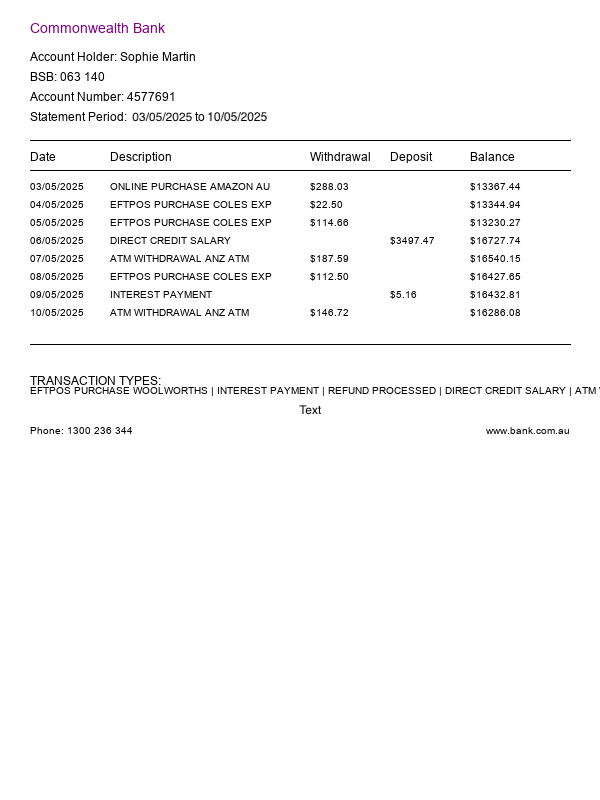

In [5]:
# Display the loaded image for visual verification
print("🖼️  Bank statement image:")
display(image)

In [6]:
# Cell 9: Image preprocessing for InternVL3.5 (Official implementation)

# Official InternVL3 image preprocessing (from docs)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.229)

def build_transform(input_size):
    """Build image transformation pipeline with ImageNet normalization."""
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    """Find the closest aspect ratio from target ratios based on image dimensions."""
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=None, image_size=448, use_thumbnail=False):
    """
    Dynamically preprocess image by splitting into tiles based on aspect ratio.
    
    Args:
        image: PIL Image
        min_num: Minimum number of tiles
        max_num: Maximum number of tiles (from CONFIG['MAX_TILES'])
        image_size: Size of each tile (448 for InternVL3)
        use_thumbnail: Whether to include thumbnail image
    
    Returns:
        List of PIL Image tiles
    """
    # Use CONFIG if max_num not specified
    if max_num is None:
        max_num = CONFIG['MAX_TILES']
    
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # Generate target aspect ratios
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # Find best aspect ratio
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # Calculate target dimensions
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # Resize and split into tiles
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    
    assert len(processed_images) == blocks
    
    # Add thumbnail if requested
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    
    return processed_images

def load_image(image_file, input_size=448, max_num=None):
    """
    Load and preprocess image for InternVL3.5.
    
    Args:
        image_file: Path to image or PIL Image object
        input_size: Size of each tile (448 for InternVL3)
        max_num: Max number of tiles (uses CONFIG['MAX_TILES'] if None)
    
    Returns:
        pixel_values: Preprocessed tensor ready for model.chat()
    """
    # Use CONFIG if max_num not specified
    if max_num is None:
        max_num = CONFIG['MAX_TILES']
    
    # Handle both path string and PIL Image
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file
    
    # Build transform and preprocess
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(img) for img in images]
    pixel_values = torch.stack(pixel_values)
    
    return pixel_values

print("✅ InternVL3.5 image preprocessing functions defined")
print(f"🔲 Using max_num={CONFIG['MAX_TILES']} tiles (from CONFIG)")
print(f"💡 Image preprocessing: ImageNet normalization + dynamic tiling")

✅ InternVL3.5 image preprocessing functions defined
🔲 Using max_num=36 tiles (from CONFIG)
💡 Image preprocessing: ImageNet normalization + dynamic tiling


# Bank Statement Extraction Protocol (2-Turn Balance-Description)
- Turn 0: Identify actual table headers
- Turn 1: Extract using balance-description prompt (format-agnostic)
- Python: Parse hierarchical output, filter, and extract schema fields

In [7]:
# Cell 11: Turn 0 - Identify table headers (prompt)
# TURN 0: Identify Table Headers
# First, identify the actual column headers used in this specific bank statement

prompt = """
Look at the transaction table in this bank statement image.

IMPORTANT STRUCTURAL NOTE:
Some bank statements show dates as section headings with multiple transactions underneath.
If you see this structure, remember that each transaction needs its explicit date in the final output.

What are the exact column header names used in the transaction table?

List each column header exactly as it appears, in order from left to right.
Do not interpret or rename them - use the EXACT text from the image.
"""

print("💬 TURN 0: Identifying actual table headers")
print("🤖 Generating response with InternVL3.5-8B...")

💬 TURN 0: Identifying actual table headers
🤖 Generating response with InternVL3.5-8B...


In [8]:
# Cell 12: Turn 0 - Execute and parse headers (InternVL3.5-8B version)

print("💬 TURN 0: Identifying actual table headers")
print("🤖 Generating response with InternVL3.5-8B (bfloat16)...")

# Load and preprocess image for InternVL3.5 (uses CONFIG['MAX_TILES'])
pixel_values = load_image(imageName, input_size=448)

# Move to correct device and dtype for InternVL3.5-8B
# CRITICAL: Use bfloat16 for non-quantized H200 models
vision_device = 'cuda:0'  # Vision model is on GPU 0
model_dtype = torch.bfloat16
pixel_values = pixel_values.to(dtype=model_dtype, device=vision_device)

# Generate response using chat() method
cleanedOutput = model.chat(
    tokenizer=tokenizer,
    pixel_values=pixel_values,
    question=prompt,
    generation_config={
        "max_new_tokens": CONFIG['MAX_NEW_TOKENS'],
        "do_sample": False  # Greedy decoding for consistency
    }
)

# Clean InternVL3 artifacts:
# 1. Remove image markdown placeholder (![...])
# 2. Remove markdown code fences (```markdown and ```)
lines = cleanedOutput.split("\n")
cleaned_lines = []
for line in lines:
    stripped = line.strip()
    # Skip image markdown, code fences, and empty fence markers
    if stripped.startswith("!["):
        continue
    if stripped in ["```markdown", "```", "```md"]:
        continue
    cleaned_lines.append(line)

cleanedOutput = "\n".join(cleaned_lines)

print("✅ Response generated successfully!")
print("\n" + "=" * 60)
print("TURN 0 - IDENTIFIED TABLE HEADERS:")
print("=" * 60)
print(cleanedOutput)
print("=" * 60)

# CRITICAL: Parse the identified headers for use in subsequent turns
# Extract column names from the response
header_lines = [line.strip() for line in cleanedOutput.split('\n') if line.strip()]
identified_headers = []

# Look for numbered list or bullet points
for line in header_lines:
    # Remove common list markers
    cleaned = line.lstrip('0123456789.-•* ').strip()
    
    # Strip markdown bold formatting
    cleaned = cleaned.replace('**', '').replace('__', '')
    
    # Skip section headers (lines ending with colon)
    if cleaned.endswith(':'):
        continue
    
    # Skip long sentences (likely explanatory text, not headers)
    if len(cleaned) > 40:
        continue
        
    if cleaned and len(cleaned) > 2:  # Ignore very short strings
        identified_headers.append(cleaned)

print(f"\n📋 Parsed {len(identified_headers)} column headers:")
for i, header in enumerate(identified_headers, 1):
    print(f"  {i}. '{header}'")

# Store headers for use in subsequent turns
table_headers = identified_headers

# Save the table headers
output_path = Path("ivl3_5_8b_2turn_table_headers.txt")
with output_path.open("w", encoding="utf-8") as text_file:
    text_file.write(cleanedOutput)

print(f"\n✅ Table headers saved to: {output_path}")
print("💡 These LITERAL header names will be used in Turn 1 balance-description prompt")

💬 TURN 0: Identifying actual table headers
🤖 Generating response with InternVL3.5-8B (bfloat16)...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


✅ Response generated successfully!

TURN 0 - IDENTIFIED TABLE HEADERS:
The exact column header names used in the transaction table are:

1. Date
2. Description
3. Withdrawal
4. Deposit
5. Balance

📋 Parsed 5 column headers:
  1. 'Date'
  2. 'Description'
  3. 'Withdrawal'
  4. 'Deposit'
  5. 'Balance'

✅ Table headers saved to: ivl3_5_8b_2turn_table_headers.txt
💡 These LITERAL header names will be used in Turn 1 balance-description prompt


## Pattern Matching: Map Generic Concepts to Actual Headers

Different bank statements use different column names. Use pattern matching to identify:
- Which header represents **Date**
- Which header represents **Description/Details**  
- Which header represents **Debit/Withdrawal**
- Which header represents **Credit/Deposit**
- Which header represents **Balance**

In [9]:
# Cell 14: Pattern Matching - Map headers to generic columns
# Pattern Matching: Map extracted headers to generic concepts
# This handles variety in bank statement column naming conventions

# Pattern keywords for each concept (in priority order)
DATE_PATTERNS = ['date', 'day', 'transaction date', 'trans date']
DESCRIPTION_PATTERNS = [
    'description', 'details', 'transaction details', 'trans details',
    'particulars', 'narrative', 'transaction', 'trans'
]
DEBIT_PATTERNS = ['debit', 'withdrawal', 'withdrawals', 'paid', 'paid out', 'spent', 'dr']
CREDIT_PATTERNS = ['credit', 'deposit', 'deposits', 'received', 'cr']
BALANCE_PATTERNS = ['balance', 'bal', 'running balance']

# NEW: Pattern for single-column transaction formats (e.g., "Amount" instead of separate Debit/Credit)
AMOUNT_PATTERNS = ['amount', 'amt', 'value', 'total']

def match_header(headers, patterns, fallback=None):
    """Match a header using pattern keywords.
    
    Matching strategy:
    1. Exact match (case-insensitive)
    2. Substring match (only for patterns with length > 2 to avoid false positives)
    """
    headers_lower = [h.lower() for h in headers]
    
    # Try exact match first
    for pattern in patterns:
        for i, header_lower in enumerate(headers_lower):
            if pattern == header_lower:
                return headers[i]
    
    # Try substring match (only for patterns longer than 2 chars)
    for pattern in patterns:
        if len(pattern) > 2:  # Avoid false positives like 'cr' matching 'description'
            for i, header_lower in enumerate(headers_lower):
                if pattern in header_lower:
                    return headers[i]
    
    return fallback

# Perform pattern matching on extracted headers
date_col = match_header(table_headers, DATE_PATTERNS, fallback=table_headers[0] if table_headers else 'Date')
desc_col = match_header(table_headers, DESCRIPTION_PATTERNS, fallback=table_headers[1] if len(table_headers) > 1 else 'Description')

# NEW: First try to match a generic "Amount" column (for 4-column formats)
amount_col = match_header(table_headers, AMOUNT_PATTERNS, fallback=None)

# Use amount_col as fallback if no separate debit/credit columns exist
# This handles formats like: Date | Description | Amount | Balance
debit_col = match_header(table_headers, DEBIT_PATTERNS, fallback=amount_col if amount_col else 'Debit')
credit_col = match_header(table_headers, CREDIT_PATTERNS, fallback=amount_col if amount_col else 'Credit')
balance_col = match_header(table_headers, BALANCE_PATTERNS, fallback='Balance')

print("=" * 60)
print("PATTERN MATCHING RESULTS:")
print("=" * 60)
print(f"📋 Extracted Headers: {table_headers}")
print(f"\n🔍 Mapped Columns:")
print(f"  Date        → '{date_col}'")
print(f"  Description → '{desc_col}'")
print(f"  Debit       → '{debit_col}'")
print(f"  Credit      → '{credit_col}'")
print(f"  Balance     → '{balance_col}'")
if amount_col:
    print(f"\n💡 Single-column format detected: '{amount_col}' used for both debit and credit")
print("=" * 60)
print("\n✅ These literal column names will be used in Turn 1 balance-description prompt")
print("💡 Adjust patterns above if matching fails for your bank statement format")

PATTERN MATCHING RESULTS:
📋 Extracted Headers: ['Date', 'Description', 'Withdrawal', 'Deposit', 'Balance']

🔍 Mapped Columns:
  Date        → 'Date'
  Description → 'Description'
  Debit       → 'Withdrawal'
  Credit      → 'Deposit'
  Balance     → 'Balance'

✅ These literal column names will be used in Turn 1 balance-description prompt
💡 Adjust patterns above if matching fails for your bank statement format


## Turn 1: Balance-Description Extraction Prompt

**Key Insight**: Instead of extracting a markdown table, we ask the model to list balances with their associated transaction details. This approach:

1. **Anchors to Balance column** - Every transaction has a balance
2. **Works for all formats** - Date-per-row AND date-grouped formats
3. **Hierarchical output** - Easy to parse programmatically
4. **No date format classification** - Eliminates Turn 0.5 entirely

In [10]:
# Cell 16: Generate Balance-Description Extraction Prompt

# Build the balance-description extraction prompt using LITERAL column names from Turn 0
extraction_prompt = f"""List all the balances in the {balance_col} column, including:
- Date from the Date Header of the balance
- {desc_col}
- {debit_col} Amount or "NOT_FOUND"
- {credit_col} Amount or "NOT_FOUND"

Format each balance entry like this:
1. **[Date]**
   - {desc_col}: [description text]
   - {debit_col}: [amount or NOT_FOUND]
   - {credit_col}: [amount or NOT_FOUND]
   - {balance_col}: [balance amount]

CRITICAL RULES:
1. List EVERY balance entry in order from top to bottom
2. For date-grouped statements: Use the date heading for all transactions under it
3. Include the FULL description text, not abbreviated
4. If amount is in {debit_col} column, put it there and use NOT_FOUND for {credit_col}
5. If amount is in {credit_col} column, put it there and use NOT_FOUND for {debit_col}
6. Do NOT skip any transactions
"""

print("\n" + "=" * 60)
print("Turn 1 Balance-Description Extraction Prompt:")
print("=" * 60)
print(f"\n{extraction_prompt}")
print("=" * 60 + "\n")


Turn 1 Balance-Description Extraction Prompt:

List all the balances in the Balance column, including:
- Date from the Date Header of the balance
- Description
- Withdrawal Amount or "NOT_FOUND"
- Deposit Amount or "NOT_FOUND"

Format each balance entry like this:
1. **[Date]**
   - Description: [description text]
   - Withdrawal: [amount or NOT_FOUND]
   - Deposit: [amount or NOT_FOUND]
   - Balance: [balance amount]

CRITICAL RULES:
1. List EVERY balance entry in order from top to bottom
2. For date-grouped statements: Use the date heading for all transactions under it
3. Include the FULL description text, not abbreviated
4. If amount is in Withdrawal column, put it there and use NOT_FOUND for Deposit
5. If amount is in Deposit column, put it there and use NOT_FOUND for Withdrawal
6. Do NOT skip any transactions




In [11]:
# Cell 17: Turn 1 - Execute Balance-Description Extraction (InternVL3.5-8B, INDEPENDENT fresh context)

print("🤖 Generating response with InternVL3.5-8B (bfloat16)...")

# CRITICAL: Reload image for fresh context (independent turn, not continuing conversation)
# Uses CONFIG['MAX_TILES'] automatically
pixel_values = load_image(imageName, input_size=448)

# Move to correct device and dtype
# CRITICAL: Use bfloat16 for non-quantized H200 models
pixel_values = pixel_values.to(dtype=torch.bfloat16, device='cuda:0')

# Generate response using chat() method with balance-description prompt
cleanedOutput2 = model.chat(
    tokenizer=tokenizer,
    pixel_values=pixel_values,
    question=extraction_prompt,
    generation_config={
        "max_new_tokens": CONFIG['MAX_NEW_TOKENS'],
        "do_sample": False
    }
)

# Clean InternVL3 artifacts:
# 1. Remove image markdown placeholder (![...])
# 2. Remove markdown code fences (```markdown and ```)
lines = cleanedOutput2.split("\n")
cleaned_lines = []
for line in lines:
    stripped = line.strip()
    # Skip image markdown, code fences, and empty fence markers
    if stripped.startswith("!["):
        continue
    if stripped in ["```markdown", "```", "```md"]:
        continue
    cleaned_lines.append(line)

cleanedOutput2 = "\n".join(cleaned_lines)

print("\n✅ Turn 1 balance-description extraction complete!")

print("\n" + "=" * 60)
print("TURN 1 - BALANCE-DESCRIPTION OUTPUT:")
print("=" * 60)
print(cleanedOutput2)
print("=" * 60)

# Save the balance-description output
output_path = Path("ivl3_5_8b_2turn_balance_description.txt")
with output_path.open("w", encoding="utf-8") as text_file:
    text_file.write(cleanedOutput2)

print(f"\n✅ Balance-description output saved to: {output_path}")

🤖 Generating response with InternVL3.5-8B (bfloat16)...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.



✅ Turn 1 balance-description extraction complete!

TURN 1 - BALANCE-DESCRIPTION OUTPUT:
1. **03/05/2025**
   - Description: ONLINE PURCHASE AMAZON AU
   - Withdrawal: $288.03
   - Deposit: NOT_FOUND
   - Balance: $13367.44

2. **04/05/2025**
   - Description: EFTPOS PURCHASE COLES EXP
   - Withdrawal: $22.50
   - Deposit: NOT_FOUND
   - Balance: $13344.94

3. **05/05/2025**
   - Description: EFTPOS PURCHASE COLES EXP
   - Withdrawal: $114.66
   - Deposit: NOT_FOUND
   - Balance: $13230.27

4. **06/05/2025**
   - Description: DIRECT CREDIT SALARY
   - Withdrawal: NOT_FOUND
   - Deposit: $3497.47
   - Balance: $16727.74

5. **07/05/2025**
   - Description: ATM WITHDRAWAL ANZ ATM
   - Withdrawal: $187.59
   - Deposit: NOT_FOUND
   - Balance: $16540.15

6. **08/05/2025**
   - Description: EFTPOS PURCHASE COLES EXP
   - Withdrawal: $112.50
   - Deposit: NOT_FOUND
   - Balance: $16427.65

7. **09/05/2025**
   - Description: INTEREST PAYMENT
   - Withdrawal: NOT_FOUND
   - Deposit: $5.16
   

## Python Parsing: Parse Balance-Description Output

Parse the hierarchical balance-description output into structured rows, filter for debit transactions, and extract schema fields.

In [12]:
# Cell 19: Parse Balance-Description Output and Extract Schema Fields

def parse_balance_description_response(response_text, date_col, desc_col, debit_col, credit_col, balance_col):
    """Parse hierarchical balance-description response into list of transaction dictionaries.
    
    Expected format:
    1. **[Date]**
       - Description: [text]
       - Debit: [amount or NOT_FOUND]
       - Credit: [amount or NOT_FOUND]
       - Balance: [amount]
    """
    rows = []
    current_date = None
    current_transaction = {}
    
    lines = response_text.strip().split("\n")
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        # Check for date header patterns:
        # Pattern 1: "1. **15 Mar 2024**" or "1. **Mon 15 Mar 2024**"
        date_match = re.match(r"^\d+\.\s*\*?\*?([A-Za-z]{3}\s+\d{1,2}\s+[A-Za-z]{3}\s+\d{4})\*?\*?", line)
        if not date_match:
            # Pattern 2: "1. **15/03/2024**" or similar
            date_match = re.match(r"^\d+\.\s*\*?\*?(\d{1,2}[/\-]\d{1,2}[/\-]\d{2,4})\*?\*?", line)
        if not date_match:
            # Pattern 3: "1. **March 15, 2024**"
            date_match = re.match(r"^\d+\.\s*\*?\*?([A-Za-z]+\s+\d{1,2},?\s+\d{4})\*?\*?", line)
        if not date_match:
            # Pattern 4: "**15 Mar 2024**" (without number prefix)
            date_match = re.match(r"^\*\*([A-Za-z]{3}\s+\d{1,2}\s+[A-Za-z]{3}\s+\d{4})\*\*", line)
        if not date_match:
            # Pattern 5: Just the date with number prefix "1. 15 Mar 2024"
            date_match = re.match(r"^\d+\.\s+([A-Za-z]{3}\s+\d{1,2}\s+[A-Za-z]{3}\s+\d{4})", line)
        
        if date_match:
            # Save previous transaction if exists
            if current_transaction and current_date:
                current_transaction[date_col] = current_date
                rows.append(current_transaction)
            
            # Start new transaction with this date
            current_date = date_match.group(1).strip('*').strip()
            current_transaction = {}
            continue
        
        # Check for field lines: "- Description: ..." or "- Transaction: ..."
        field_match = re.match(r"^\s*-\s*([\w\s]+):\s*(.+)$", line)
        if field_match:
            field_name = field_match.group(1).strip()
            field_value = field_match.group(2).strip()
            
            # Map field names to column names (case-insensitive)
            field_lower = field_name.lower()
            
            if field_lower in ['description', 'transaction', 'details', 'particulars', desc_col.lower()]:
                current_transaction[desc_col] = field_value
            elif field_lower in ['debit', 'withdrawal', 'dr', debit_col.lower()]:
                # Handle NOT_FOUND
                if field_value.upper() == 'NOT_FOUND' or field_value == '-':
                    current_transaction[debit_col] = ''
                else:
                    current_transaction[debit_col] = field_value
            elif field_lower in ['credit', 'deposit', 'cr', credit_col.lower()]:
                # Handle NOT_FOUND
                if field_value.upper() == 'NOT_FOUND' or field_value == '-':
                    current_transaction[credit_col] = ''
                else:
                    current_transaction[credit_col] = field_value
            elif field_lower in ['balance', 'bal', balance_col.lower()]:
                current_transaction[balance_col] = field_value
    
    # Don't forget the last transaction
    if current_transaction and current_date:
        current_transaction[date_col] = current_date
        rows.append(current_transaction)
    
    return rows


def parse_markdown_table(markdown_text):
    """Fallback: Parse markdown table into list of dictionaries.
    
    CRITICAL: Must preserve empty columns for correct Debit/Credit alignment!
    """
    lines = [line.strip() for line in markdown_text.strip().split('\n') if line.strip()]
    
    # Find header row (first line with pipes)
    header_idx = None
    for i, line in enumerate(lines):
        if '|' in line:
            # Skip separator rows (contain only pipes, hyphens, and spaces)
            cleaned = line.replace('|', '').replace('-', '').replace(' ', '')
            if cleaned:  # Has actual content, not just separators
                header_idx = i
                break
    
    if header_idx is None:
        return []
    
    # Parse headers - KEEP empty values to preserve column positions
    header_line = lines[header_idx]
    header_parts = [h.strip() for h in header_line.split('|')]
    # Remove leading/trailing empty strings from pipe delimiters
    if header_parts and header_parts[0] == '':
        header_parts = header_parts[1:]
    if header_parts and header_parts[-1] == '':
        header_parts = header_parts[:-1]
    # Filter out any remaining empty headers
    headers = [h for h in header_parts if h]
    
    # Parse data rows (skip header and separator)
    rows = []
    for idx, line in enumerate(lines[header_idx + 1:], start=header_idx+1):
        if '|' not in line:
            continue
            
        # Skip separator rows
        cleaned = line.replace("|", "").replace("-", "").replace(" ", "").replace(":", "")
        if not cleaned:
            continue
        
        # Parse values - KEEP empty values to preserve column positions!
        value_parts = [v.strip() for v in line.split('|')]
        # Remove leading/trailing empty strings from pipe delimiters
        if value_parts and value_parts[0] == '':
            value_parts = value_parts[1:]
        if value_parts and value_parts[-1] == '':
            value_parts = value_parts[:-1]
        
        # Match to headers length
        if len(value_parts) == len(headers):
            rows.append(dict(zip(headers, value_parts)))
    
    return rows


def filter_debit_transactions(rows, debit_col):
    """Filter rows to only those with debit (purchase) amounts > 0.
    
    CRITICAL: For tax purposes, we only want transactions where taxpayer PAID money (debits).
    """
    debit_rows = []
    for row in rows:
        debit_value = row.get(debit_col, '').strip()
        # Include row if debit column has a numeric value (not empty, not NOT_FOUND)
        if debit_value and debit_value.upper() != 'NOT_FOUND':
            # Try to parse as number to confirm it's a valid amount
            try:
                amount = float(debit_value.replace(',', '').replace('$', '').strip())
                if amount > 0:
                    debit_rows.append(row)
            except ValueError:
                # If can't parse as number, skip this row
                pass
    
    return debit_rows


def extract_schema_fields(rows, date_col, desc_col, debit_col):
    """Extract fields in universal.yaml schema format."""
    if not rows:
        return {
            'TRANSACTION_DATES': 'NOT_FOUND',
            'LINE_ITEM_DESCRIPTIONS': 'NOT_FOUND',
            'TRANSACTION_AMOUNTS_PAID': 'NOT_FOUND',
            'STATEMENT_DATE_RANGE': 'NOT_FOUND'
        }
    
    # Extract lists
    dates = []
    descriptions = []
    amounts = []
    
    for row in rows:
        date = row.get(date_col, '').strip()
        desc = row.get(desc_col, '').strip()
        amount = row.get(debit_col, '').strip()
        
        if date:
            dates.append(date)
        if desc:
            descriptions.append(desc)
        if amount:
            amounts.append(amount)
    
    # Calculate statement date range - use literal date format from image
    # No parsing, no year assumption - just "earliest date - latest date"
    date_range = 'NOT_FOUND'
    if dates:
        # Use first and last date as-is (same format as in the image)
        date_range = f"{dates[0]} - {dates[-1]}"
    
    return {
        'TRANSACTION_DATES': ' | '.join(dates) if dates else 'NOT_FOUND',
        'LINE_ITEM_DESCRIPTIONS': ' | '.join(descriptions) if descriptions else 'NOT_FOUND',
        'TRANSACTION_AMOUNTS_PAID': ' | '.join(amounts) if amounts else 'NOT_FOUND',
        'STATEMENT_DATE_RANGE': date_range
    }


print("=" * 60)
print("PARSING TURN 1 BALANCE-DESCRIPTION OUTPUT:")
print("=" * 60)

# Try balance-description parsing first
all_rows = parse_balance_description_response(cleanedOutput2, date_col, desc_col, debit_col, credit_col, balance_col)

# Fallback to markdown table parsing if balance-description parsing fails
if not all_rows:
    print("⚠️  Balance-description parsing returned 0 rows, trying markdown table fallback...")
    all_rows = parse_markdown_table(cleanedOutput2)

print(f"\n📊 Parsed {len(all_rows)} total transactions")

if all_rows:
    # Show sample parsed row
    print(f"\n🔍 Sample parsed row:")
    for key, value in all_rows[0].items():
        print(f"  {key}: '{value}'")

# Filter to only debit (purchase) transactions - Python filtering, not LLM!
debit_rows = filter_debit_transactions(all_rows, debit_col)

print(f"\n💰 Filtered to {len(debit_rows)} debit transactions (taxpayer purchases)")
print("\n" + "=" * 60)
print("DEBIT TRANSACTIONS (WHAT TAXPAYER PAID):")
print("=" * 60)
for i, row in enumerate(debit_rows, 1):
    print(f"\nTransaction {i}:")
    print(f"  {date_col}: {row.get(date_col, '')}")
    print(f"  {desc_col}: {row.get(desc_col, '')}")
    print(f"  {debit_col}: {row.get(debit_col, '')}")

# Extract schema fields using the LITERAL column names from pattern matching
schema_fields = extract_schema_fields(debit_rows, date_col, desc_col, debit_col)

print("\n" + "=" * 60)
print("EXTRACTED SCHEMA FIELDS (TAX-RELEVANT DATA):")
print("=" * 60)
for field, value in schema_fields.items():
    print(f"{field}: {value}")
print("=" * 60)

# Save to file
output_path = Path("ivl3_5_8b_2turn_extracted_fields.txt")
with output_path.open("w", encoding="utf-8") as f:
    for field, value in schema_fields.items():
        f.write(f"{field}: {value}\n")

print(f"\n✅ Schema fields saved to: {output_path}")
print(f"💡 Fields extracted from columns: '{date_col}' | '{desc_col}' | '{debit_col}'")
print(f"🎯 Success: 2-Turn Balance-Description approach with Python parsing + filtering")

PARSING TURN 1 BALANCE-DESCRIPTION OUTPUT:

📊 Parsed 8 total transactions

🔍 Sample parsed row:
  Description: 'ONLINE PURCHASE AMAZON AU'
  Withdrawal: '$288.03'
  Deposit: ''
  Balance: '$13367.44'
  Date: '03/05/2025'

💰 Filtered to 6 debit transactions (taxpayer purchases)

DEBIT TRANSACTIONS (WHAT TAXPAYER PAID):

Transaction 1:
  Date: 03/05/2025
  Description: ONLINE PURCHASE AMAZON AU
  Withdrawal: $288.03

Transaction 2:
  Date: 04/05/2025
  Description: EFTPOS PURCHASE COLES EXP
  Withdrawal: $22.50

Transaction 3:
  Date: 05/05/2025
  Description: EFTPOS PURCHASE COLES EXP
  Withdrawal: $114.66

Transaction 4:
  Date: 07/05/2025
  Description: ATM WITHDRAWAL ANZ ATM
  Withdrawal: $187.59

Transaction 5:
  Date: 08/05/2025
  Description: EFTPOS PURCHASE COLES EXP
  Withdrawal: $112.50

Transaction 6:
  Date: 10/05/2025
  Description: ATM WITHDRAWAL ANZ ATM
  Withdrawal: $146.72

EXTRACTED SCHEMA FIELDS (TAX-RELEVANT DATA):
TRANSACTION_DATES: 03/05/2025 | 04/05/2025 | 05/05/20

## Summary: 2-Turn Balance-Description Approach

### What We Achieved:
1. **Turn 0**: Identified column headers from the bank statement image
2. **Turn 1**: Extracted transactions using balance-description prompt (format-agnostic)
3. **Python**: Parsed hierarchical output, filtered debits, extracted schema fields

### Why This Works:
- **Balance anchoring**: Every transaction has a balance - use it as the anchor point
- **No date format classification**: Works for BOTH date-per-row AND date-grouped formats
- **Hierarchical output**: Clear structure for reliable parsing
- **Python filtering**: Accurate debit/credit separation for tax purposes

### Comparison to 3-Turn Table Approach:
| Aspect | 3-Turn Table | 2-Turn Balance-Description |
|--------|--------------|---------------------------|
| Turns needed | 3 (headers, date format, table) | 2 (headers, extraction) |
| Date format handling | Turn 0.5 classification | Built-in to prompt |
| Output format | Markdown table | Hierarchical list |
| Complexity | Higher | Lower |
| Format flexibility | Needs format-specific prompts | Works for all formats |